In [1]:
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from scipy.stats import spearmanr
import numpy as np
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

/Users/jameelamer/MasterProject/Summarization/summrization_webapp/flaskProject2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the STS Benchmark dataset (English - test split)
dataset = load_dataset("stsb_multi_mt", name="en", split="test")
print(dataset)

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1379
})


In [5]:
import time
# Extract sentences and similarity scores
sentences1 = dataset['sentence1']
sentences2 = dataset['sentence2']
labels = np.array(dataset['similarity_score']) / 5.0  # normalize to [0, 1]

In [17]:
labels = np.array(dataset["similarity_score"]) / 5.0  # Normalize scores to 0-1

# --- 1. GloVe Encoding (average word embeddings) ---
print("Loading GloVe...")
glove_model = api.load('glove-wiki-gigaword-100')

def encode_glove(sentences):
    vectors = []
    for sentence in sentences:
        words = sentence.lower().split()
        word_vecs = [glove_model[word] for word in words if word in glove_model]
        if word_vecs:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(100))
    return np.array(vectors)

print("Encoding with GloVe...")
glove_sent1 = encode_glove(sentences1)
glove_sent2 = encode_glove(sentences2)
glove_sims = [cosine_similarity([a], [b])[0][0] for a, b in zip(glove_sent1, glove_sent2)]

# --- 2. SBERT (MiniLM) ---
sbert = SentenceTransformer("all-MiniLM-L6-v2")
print("Encoding with SBERT...")
sbert_sent1 = sbert.encode(sentences1, convert_to_numpy=True, show_progress_bar=True)
sbert_sent2 = sbert.encode(sentences2, convert_to_numpy=True, show_progress_bar=True)
sbert_sims = [cosine_similarity([a], [b])[0][0] for a, b in zip(sbert_sent1, sbert_sent2)]

# --- 3. E5 ---
e5 = SentenceTransformer("intfloat/e5-base-v2")
print("Encoding with E5...")
e5_sent1 = e5.encode([f"query: {s}" for s in sentences1], convert_to_numpy=True, show_progress_bar=True)
e5_sent2 = e5.encode([f"passage: {s}" for s in sentences2], convert_to_numpy=True, show_progress_bar=True)
e5_sims = [cosine_similarity([a], [b])[0][0] for a, b in zip(e5_sent1, e5_sent2)]

# --- 4. bge ---
bge = SentenceTransformer("BAAI/bge-base-en-v1.5")
print("Encoding with bge...")
bge_sent1 = bge.encode([f"query: {s}" for s in sentences1], convert_to_numpy=True, show_progress_bar=True)
bge_sent2 = bge.encode([f"passage: {s}" for s in sentences2], convert_to_numpy=True, show_progress_bar=True)
bge_sims = [cosine_similarity([a], [b])[0][0] for a, b in zip(bge_sent1, bge_sent2)]

# --- Evaluation Function ---
def evaluate(name, preds):
    start = time.time()
    pearson = pearsonr(preds, labels)[0]
    spearman = spearmanr(preds, labels)[0]
    end = time.time()
    print(f" {name} Results:")
    print(f"  Pearson Correlation : {pearson:.4f}")
    print(f"  Spearman Correlation: {spearman:.4f}")
    avg_time_per_embedding = (end - start) 
    print(f" time : {avg_time_per_embedding:.4f} seconds")
    return pearson, spearman

# --- Run Evaluations ---
evaluate("GloVe", glove_sims)
evaluate("SBERT (all-MiniLM-L6-v2)", sbert_sims)
evaluate("E5 (intfloat/e5-base-v2)", e5_sims)
evaluate("bge", bge_sims)

Loading GloVe...
Encoding with GloVe...
Encoding with SBERT...


Batches: 100%|██████████| 44/44 [00:00<00:00, 76.14it/s]


Encoding with E5...


Batches: 100%|██████████| 44/44 [00:02<00:00, 20.08it/s]


Encoding with bge...


Batches: 100%|██████████| 44/44 [00:02<00:00, 19.99it/s]


 GloVe Results:
  Pearson Correlation : 0.2546
  Spearman Correlation: 0.2868
 time : 0.0024 seconds
 SBERT (all-MiniLM-L6-v2) Results:
  Pearson Correlation : 0.8274
  Spearman Correlation: 0.8203
 time : 0.0012 seconds
 E5 (intfloat/e5-base-v2) Results:
  Pearson Correlation : 0.8460
  Spearman Correlation: 0.8583
 time : 0.0010 seconds
 bge Results:
  Pearson Correlation : 0.7993
  Spearman Correlation: 0.7848
 time : 0.0010 seconds


(0.7993460368079676, 0.7847646167087401)

0.827406425807265 1379


In [ ]:
# --- Evaluation Function ---
def evaluate(name, preds):
    start = time.time()
    pearson = pearsonr(preds, labels)[0]
    spearman = spearmanr(preds, labels)[0]
    end = time.time()
    print(f" {name} Results:")
    print(f"  Pearson Correlation : {pearson:.4f}")
    print(f"  Spearman Correlation: {spearman:.4f}")
    avg_time_per_embedding = (end - start) 
    print(f" time : {avg_time_per_embedding:.4f} seconds")
    return pearson, spearman

# --- Run Evaluations ---
evaluate("GloVe", glove_sims)
evaluate("SBERT (all-MiniLM-L6-v2)", sbert_sims)
evaluate("E5 (intfloat/e5-base-v2)", e5_sims)
evaluate("bge", bge_sims)

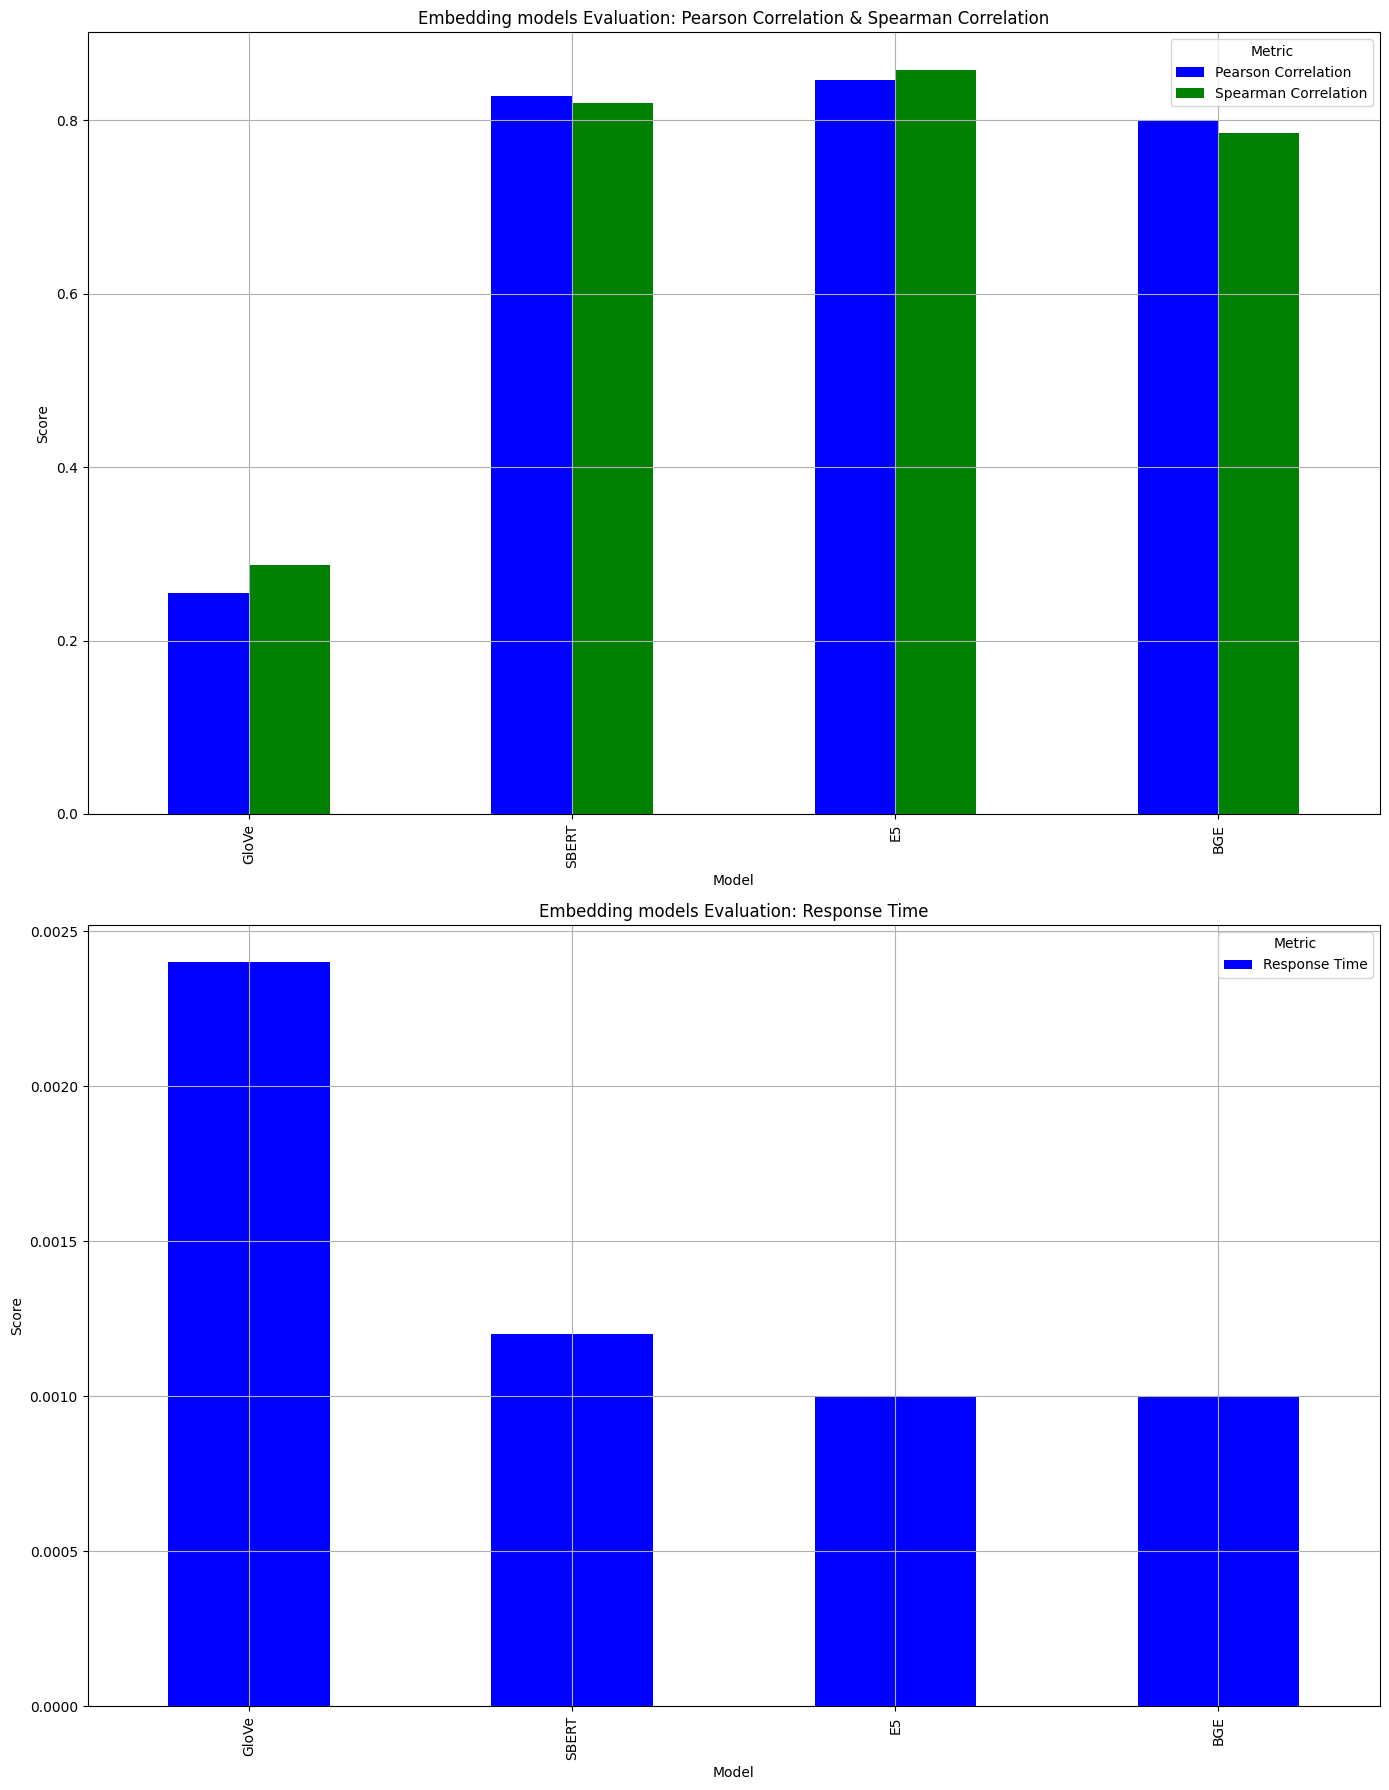

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset for large documents
data = {
    'Model': ['GloVe', 'SBERT', 'E5', 'BGE'],
    'Pearson Correlation': [0.2546, 0.8274, 0.8460, 0.7993],
    'Spearman Correlation': [0.2868, 0.8203, 0.8583, 0.7848],
    'Response Time': [0.0024, 0.0012, 0.0010, 0.0010]
}

# Convert to DataFrame
df_large = pd.DataFrame(data)

# Metrics and color palette
metrics = ['Pearson Correlation', 'Spearman Correlation', 'Response Time']
colors = ['blue', 'green', 'red']



fig, axes = plt.subplots(2, 1, figsize=(14, 18))
metric_sets = [metrics[:2], metrics[2:]]

for i, metric_group in enumerate(metric_sets):
    df_plot = df_large.set_index('Model')[metric_group]
    df_plot.plot(kind='bar', ax=axes[i], color=colors)
    axes[i].set_title(f'Embedding models Evaluation: {" & ".join(metric_group)}')
    axes[i].set_ylabel('Score')
    axes[i].set_xlabel('Model')
    axes[i].legend(title='Metric')
    axes[i].grid(True)

plt.tight_layout()
plt.show()